In [1]:
# Cell 1: Imports
# Install only missing packages (Kaggle already has most of them)
%pip install -q nibabel monai

# Standard libraries
import os, glob, gc, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# MONAI + medical imaging
import nibabel as nib
import monai
from monai.transforms import (
    LoadImaged, RandCropByPosNegLabeld, ScaleIntensityRanged, RandGaussianNoised,
    RandFlipd, RandScaleIntensityd, RandRotated, Compose, EnsureChannelFirstd,
    Orientationd, CropForegroundd, ResizeWithPadOrCropd, Lambdad
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import BasicUNet
from monai.metrics import DiceMetric
from monai.inferers import SlidingWindowInferer
from monai.handlers import CheckpointSaver, MeanDice, StatsHandler, ValidationHandler
from monai.handlers.utils import from_engine
from monai.engines import SupervisedTrainer, SupervisedEvaluator

# General utilities
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Memory optimization settings
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print(f"CUDA available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.1 MB/s eta 0:00:00:00:0100:01
Note: you may need 

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-09-10 04:25:46.035737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757478346.204621      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757478346.251485      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CUDA available: True


In [2]:
# Cell 2: Path
# --- LISA Task 2a (Hippocampus) dataset prep ---
# Pair training images+masks and register official validation set (NO local split here).

from pathlib import Path
import re, csv
import numpy as np
import nibabel as nib

# ========== CONFIG: Kaggle paths ==========
IMAGE_DIR     = Path("/kaggle/input/subtask-2a-hippocampus-segmentations/Low Field Images")
HIPP_MASK_DIR = Path("/kaggle/input/subtask-2a-hippocampus-segmentations/Subtask 2a - Hippocampus Segmentations")
OFFVAL_DIR    = Path("/kaggle/input/subtask-2a-hippocampus-segmentations/Task 2 - Segmentation Validation")

# Writable output
OUTPUT_DIR = Path("/kaggle/working/hippocampus_results")
MODEL_DIR  = OUTPUT_DIR / "models"
VIS_DIR    = OUTPUT_DIR / "visualizations"
PRED_DIR   = OUTPUT_DIR / "predictions"
for d in (OUTPUT_DIR, MODEL_DIR, VIS_DIR, PRED_DIR):
    d.mkdir(parents=True, exist_ok=True)

TRAIN_CSV  = OUTPUT_DIR / "train_pairs.csv"          # written in Cell 4
VAL_CSV    = OUTPUT_DIR / "val_pairs.csv"            # written in Cell 4
INFO_TXT   = OUTPUT_DIR / "dataset_summary.txt"
OFFVAL_CSV = OUTPUT_DIR / "official_validation_files.csv"

# ========== Helpers ==========
def is_nii(p: Path) -> bool:
    n = p.name.lower()
    return n.endswith(".nii") or n.endswith(".nii.gz")

def extract_case_id_train(p: Path):
    m = re.match(r"(LISA_\d+)", p.name)
    return m.group(1) if m else None

# Accept both with and without `_ciso`, and both .nii and .nii.gz
# Examples:
#  - LISA_VALIDATION_0001_ciso.nii.gz -> "0001"
#  - LISA_VALIDATION_0001.nii.gz      -> "0001"
#  - LISA_VALIDATION_0001.nii         -> "0001"
def extract_case_id_official_val(p: Path):
    m = re.match(r"^LISA_VALIDATION_(\d+)(?:_ciso)?\.nii(?:\.gz)?$", p.name, flags=re.IGNORECASE)
    return m.group(1) if m else None

def list_files(folder: Path):
    # Keep for training dirs that are flat
    return sorted([p for p in folder.iterdir() if p.is_file() and is_nii(p)])

# ========== Gather training files and pair by ID ==========
image_files = list_files(IMAGE_DIR)
hipp_files  = list_files(HIPP_MASK_DIR)

print("Dataset Overview:")
print(f"   Train Images dir: {IMAGE_DIR}")
print(f"   Train Masks  dir: {HIPP_MASK_DIR}")
print(f"   Found images: {len(image_files)}")
print(f"   Found masks : {len(hipp_files)}")

img_map  = {}
mask_map = {}
for p in image_files:
    cid = extract_case_id_train(p)
    if cid: img_map[cid] = p
for p in hipp_files:
    cid = extract_case_id_train(p)
    if cid: mask_map[cid] = p

common_ids  = sorted(set(img_map) & set(mask_map))
missing_img = sorted(set(mask_map) - set(img_map))
missing_msk = sorted(set(img_map)  - set(mask_map))

print(f"\nPaired cases (image+mask): {len(common_ids)}")
if missing_img:
    print(f"WARNING: {len(missing_img)} masks without images:", missing_img[:5], "...")
if missing_msk:
    print(f"WARNING: {len(missing_msk)} images without masks:", missing_msk[:5], "...")

if not common_ids:
    raise RuntimeError("No matched image–mask pairs found. Check directories/filenames.")

# Quick sanity check on one sample
sample_id   = common_ids[0]
sample_img  = nib.load(str(img_map[sample_id]))
sample_mask = nib.load(str(mask_map[sample_id]))
img_data    = sample_img.get_fdata()
mask_data   = sample_mask.get_fdata()

print(f"\nSample Data Analysis (case {sample_id}):")
print(f"   Image shape: {img_data.shape}, voxel spacing: {sample_img.header.get_zooms()[:3]} mm")
print(f"   Mask  shape: {mask_data.shape}, unique labels: {np.unique(mask_data)}")
print(f"   Image intensity range: [{img_data.min():.1f}, {img_data.max():.1f}]")

# ========== Register official validation set (for inference/submission later) ==========
# IMPORTANT: Use recursive search here (OFFVAL can have subfolders like 'Low Field Images')
off_val_files = sorted([p for p in OFFVAL_DIR.rglob("*") if p.is_file() and is_nii(p)])
print(f"\nOfficial Validation scan (recursive): {len(off_val_files)} nii/nii.gz files found under {OFFVAL_DIR}")

# Filter to only LISA_VALIDATION_* files, with or without _ciso
off_val_files = [p for p in off_val_files if extract_case_id_official_val(p) is not None]
off_val_files = sorted(off_val_files)

print(f"Official Validation (DO NOT TRAIN ON): {len(off_val_files)} files")
if off_val_files[:3]:
    print("   Sample:", [p.name for p in off_val_files[:3]])

# Create CSV mapping input file → expected submission name
# Final schema we’ll use everywhere: ["input_path","sid","out_name"]
with OFFVAL_CSV.open("w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["input_path", "sid", "out_name"])
    for p in off_val_files:
        sid = extract_case_id_official_val(p)  # e.g., "0001"
        out_name = f"LISAHF{sid}segprediction.nii.gz"  # organizer-required name
        w.writerow([str(p), sid, out_name])

print(f"OFFVAL CSV written (schema: input_path,sid,out_name): {OFFVAL_CSV}")


# ========== Write a human-readable summary ==========
with INFO_TXT.open("w") as f:
    f.write("LISA Task 2a (Hippocampus) dataset preparation\n")
    f.write("==============================================\n\n")
    f.write(f"Training images dir: {IMAGE_DIR}\n")
    f.write(f"Training masks  dir: {HIPP_MASK_DIR}\n")
    f.write(f"Official validation dir (inference-only): {OFFVAL_DIR}\n\n")
    f.write(f"Total paired cases (image+mask): {len(common_ids)}\n")
    f.write(f"CSV files created:\n - {OFFVAL_CSV}\n\n")
    f.write("Local 90/10 split and train/val CSVs will be created in Cell 4.\n")

print("\n✅ Done (prep only; no local split here).")
print(f"OFFVAL CSV written: {OFFVAL_CSV}")
print(f"Summary: {INFO_TXT}")

# ✅ Intensity stats
print("\nIntensity statistics:")
print(f"   Mean: {img_data.mean():.2f}")
print(f"   Std:  {img_data.std():.2f}")
print(f"   Min:  {img_data.min():.2f}")
print(f"   Max:  {img_data.max():.2f}")
print(f"   Median: {np.median(img_data):.2f}")
print(f"   95th percentile: {np.percentile(img_data, 95):.2f}")

Dataset Overview:
   Train Images dir: /kaggle/input/subtask-2a-hippocampus-segmentations/Low Field Images
   Train Masks  dir: /kaggle/input/subtask-2a-hippocampus-segmentations/Subtask 2a - Hippocampus Segmentations
   Found images: 79
   Found masks : 79

Paired cases (image+mask): 79

Sample Data Analysis (case LISA_0001):
   Image shape: (197, 233, 189), voxel spacing: (1.0, 1.0, 1.0) mm
   Mask  shape: (197, 233, 189), unique labels: [0. 1. 2.]
   Image intensity range: [-0.5, 16.1]

Official Validation scan (recursive): 12 nii/nii.gz files found under /kaggle/input/subtask-2a-hippocampus-segmentations/Task 2 - Segmentation Validation
Official Validation (DO NOT TRAIN ON): 12 files
   Sample: ['LISA_VALIDATION_0001_ciso.nii', 'LISA_VALIDATION_0002_ciso.nii', 'LISA_VALIDATION_0003_ciso.nii']
OFFVAL CSV written (schema: input_path,sid,out_name): /kaggle/working/hippocampus_results/official_validation_files.csv

✅ Done (prep only; no local split here).
OFFVAL CSV written: /kaggle/wo

In [3]:
# =========================
# Cell 2.1: Cross-subject registration QA (atlas alignment check)
# =========================
import os, numpy as np, nibabel as nib
from nibabel.orientations import aff2axcodes

def _vox(aff):
    return tuple(np.sqrt((aff[:3,:3]**2).sum(0)).round(5))

rows = []
for cid in common_ids:
    p = img_map[cid]
    img = nib.load(str(p))
    A = img.affine
    rows.append({
        "id": cid,
        "shape": img.shape,
        "vox": _vox(A),
        "orient": "".join(aff2axcodes(A)),
        "origin_mm": tuple(np.round(A[:3,3], 2)),
    })

shapes  = {r["shape"] for r in rows}
voxels  = {r["vox"] for r in rows}
ornts   = {r["orient"] for r in rows}
origins = np.array([r["origin_mm"] for r in rows], float)

print(f"Subjects checked: {len(rows)}")
print("Unique shapes   :", shapes)
print("Unique vox sizes:", voxels)
print("Unique orient   :", ornts)
print("Origin spread mm (per-axis range):",
      tuple(np.round(origins.max(0) - origins.min(0), 2)))

if len(voxels) > 1 or len(ornts) > 1:
    print("→ Not in a common space (varying spacing/orientation).")
elif np.any((origins.max(0) - origins.min(0)) > 20):  # 2 cm+ scatter
    print("→ Likely not atlas-registered (origins scattered).")
else:
    print("→ Consistent geometry; may still be native (not atlas).")


Subjects checked: 79
Unique shapes   : {(197, 233, 189), (195, 233, 159)}
Unique vox sizes: {(1.0, 1.0, 1.0)}
Unique orient   : {'RAS'}
Origin spread mm (per-axis range): (2.0, 0.0, 0.0)
→ Consistent geometry; may still be native (not atlas).


Visualizing Ultra Low-Field MRI and Hippocampus Segmentation


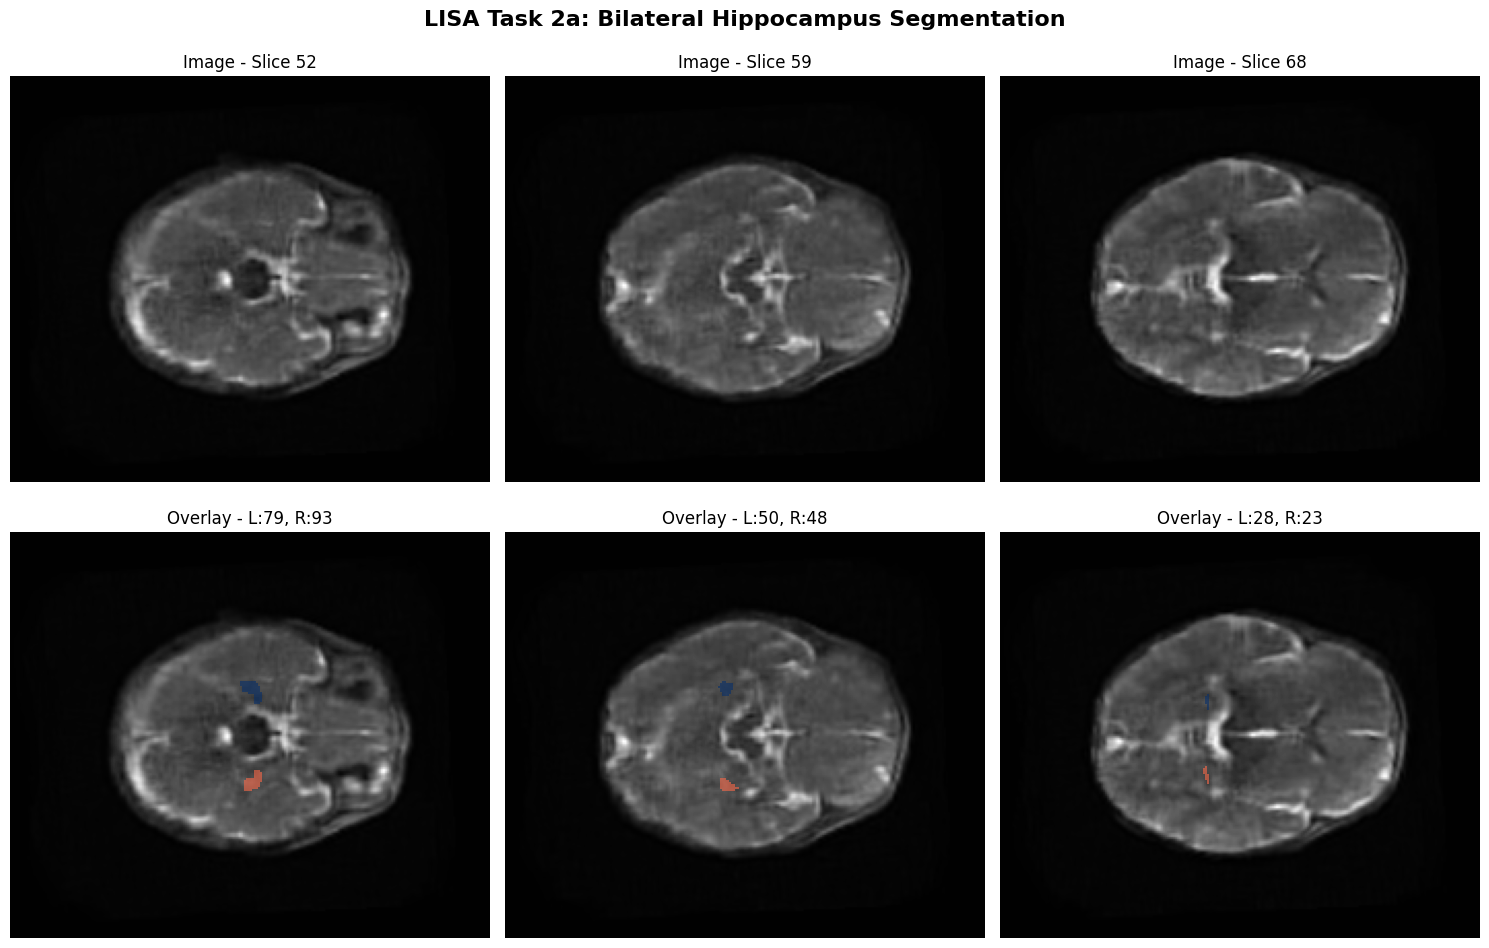


Slice Analysis:
   Total slices: 189
   Slices with hippocampus: 22
   Coverage: 11.6%
   Best slices (by content): [52, 53, 51, 50, 54]


In [4]:
# Cell 3: Find slices with hippocampus and visualize overlays
def find_hippocampus_slices(mask_volume, min_pixels=50):
    """Find slices containing significant hippocampus tissue."""
    valid_slices = []
    for z in range(mask_volume.shape[2]):
        slice_mask = mask_volume[:, :, z]
        if np.sum(slice_mask > 0) >= min_pixels:
            pixel_count = np.sum(slice_mask > 0)
            valid_slices.append((z, pixel_count))

    # Sort by hippocampus content (descending)
    valid_slices.sort(key=lambda x: x[1], reverse=True)
    return [z for z, _ in valid_slices]

def visualize_hippocampus_sample(img_data, mask_data, title="Hippocampus Segmentation"):
    """Visualize hippocampus segmentation with multiple views."""
    # Find best slices
    valid_slices = find_hippocampus_slices(mask_data)

    if len(valid_slices) >= 3:
        # Select beginning, middle, and end slices
        slice_indices = [
            valid_slices[0],           # Best slice
            valid_slices[len(valid_slices)//2],  # Middle slice
            valid_slices[-1]           # Last good slice
        ]
    else:
        slice_indices = valid_slices + [img_data.shape[2]//2] * (3 - len(valid_slices))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, slice_idx in enumerate(slice_indices):
        img_slice = img_data[:, :, slice_idx]
        mask_slice = mask_data[:, :, slice_idx]

        # Original image
        axes[0, i].imshow(img_slice, cmap='gray', origin='lower')
        axes[0, i].set_title(f'Image - Slice {slice_idx}')
        axes[0, i].axis('off')

        # Overlay segmentation
        axes[1, i].imshow(img_slice, cmap='gray', origin='lower')

        # Color code: Left hippocampus (red), Right hippocampus (blue)
        left_mask = np.ma.masked_where(mask_slice != 1, mask_slice)
        right_mask = np.ma.masked_where(mask_slice != 2, mask_slice)

        axes[1, i].imshow(left_mask, cmap='Reds', alpha=0.6, origin='lower', vmin=0, vmax=2)
        axes[1, i].imshow(right_mask, cmap='Blues', alpha=0.6, origin='lower', vmin=0, vmax=2)

        # Count pixels
        left_pixels = np.sum(mask_slice == 1)
        right_pixels = np.sum(mask_slice == 2)

        axes[1, i].set_title(f'Overlay - L:{left_pixels}, R:{right_pixels}')
        axes[1, i].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize sample data
print("Visualizing Ultra Low-Field MRI and Hippocampus Segmentation")
visualize_hippocampus_sample(img_data, mask_data, "LISA Task 2a: Bilateral Hippocampus Segmentation")

# Show statistics
valid_slices = find_hippocampus_slices(mask_data)
print(f"\nSlice Analysis:")
print(f"   Total slices: {mask_data.shape[2]}")
print(f"   Slices with hippocampus: {len(valid_slices)}")
print(f"   Coverage: {len(valid_slices)/mask_data.shape[2]*100:.1f}%")
print(f"   Best slices (by content): {valid_slices[:5]}")

In [5]:
# =========================
# Cell 4: Data splitting
# =========================
import os, csv, random
from pathlib import Path
import numpy as np

try:
    import torch
except Exception:
    torch = None

assert 'img_map' in globals() and 'mask_map' in globals() and 'common_ids' in globals(), "Run Cell 2 first."
assert 'OUTPUT_DIR' in globals() and 'OFFVAL_DIR' in globals(), "Run Cell 2 first."

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_CSV   = OUTPUT_DIR / "train_pairs.csv"
VAL_CSV     = OUTPUT_DIR / "val_pairs.csv"
# DO NOT redefine or overwrite OFFVAL_CSV here; it's written in Cell 2 with schema ["input_path","sid","out_name"]

RNG_SEED = 2025

os.environ["PYTHONHASHSEED"] = str(RNG_SEED)
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
if torch is not None:
    torch.manual_seed(RNG_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RNG_SEED)

# ---- OFFVAL leak protection ----
ids = list(common_ids)
off_p = Path(OFFVAL_DIR).resolve()
for c in ids:
    img_p  = Path(img_map[c]).resolve()
    mask_p = Path(mask_map[c]).resolve()
    assert off_p not in img_p.parents,  f"OFFVAL leak via image: {img_p}"
    assert off_p not in mask_p.parents, f"OFFVAL leak via mask:  {mask_p}"
print("🛡️ SAFETY CHECK PASSED: No OFFVAL paths in local train/val candidates.")

# ---- 80/20 split ----
rng = random.Random(RNG_SEED)
rng.shuffle(ids)
n = len(ids)
n_train   = int(0.8 * n)
train_ids = sorted(ids[:n_train])
val_ids   = sorted(ids[n_train:])

assert set(train_ids).isdisjoint(val_ids)
assert sorted(train_ids + val_ids) == sorted(ids)

def _pair_lists(id_list):
    return [img_map[c] for c in id_list], [mask_map[c] for c in id_list]

train_files, train_mask_files = _pair_lists(train_ids)
val_files,   val_mask_files   = _pair_lists(val_ids)

print("\nLocal Split (by subjects, seed={}):".format(RNG_SEED))
print(f"   Total local pairs : {n}")
print(f"   Train (80%)       : {len(train_files)}")
print(f"   Val   (20%)       : {len(val_files)}")

def create_data_dicts(files, masks):
    return [{"image": str(f), "label": str(m)} for f, m in zip(files, masks)]

train_data_dicts = create_data_dicts(train_files, train_mask_files)
val_data_dicts   = create_data_dicts(val_files,   val_mask_files)

print("\nMatched Pairs (MONAI dicts):")
print(f"   Train pairs: {len(train_data_dicts)}")
print(f"   Val pairs  : {len(val_data_dicts)}")

def write_pairs_csv(path: Path, id_list):
    with path.open("w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["case_id", "image_path", "mask_path"])
        for cid in id_list:
            w.writerow([cid, str(img_map[cid]), str(mask_map[cid])])

write_pairs_csv(TRAIN_CSV, train_ids)
write_pairs_csv(VAL_CSV,   val_ids)

print("\nCSV written (local):")
print(f"   Train: {TRAIN_CSV}")
print(f"   Val  : {VAL_CSV}")

# ---- OFFVAL enumeration (for building image-only test/offval dataset) ----
def is_nii(p: Path) -> bool:
    n = p.name.lower()
    return n.endswith(".nii") or n.endswith(".nii.gz")

def _basename_nii_like(p: Path) -> str:
    n = p.name
    if n.endswith(".nii.gz"): return n[:-7]
    if n.endswith(".nii"):    return n[:-4]
    return p.stem

offval_image_paths = sorted([p for p in OFFVAL_DIR.rglob("*") if p.is_file() and is_nii(p)])
print("\nOFFVAL/Test set (inference-only):")
print(f"   OFFVAL images: {len(offval_image_paths)}")

# This feeds test_ds/test_loader (image-only)
offval_data_dicts = [{"image": str(p)} for p in offval_image_paths]

# DO NOT write OFFVAL_CSV here (keeps schema from Cell 2 intact)

# ---- Preview ----
def _preview_pairs(files, masks, k=3, title=""):
    print(title)
    for i in range(min(k, len(files))):
        print(f"   Image: {Path(files[i]).name}")
        print(f"   Mask : {Path(masks[i]).name}")
        print()

_preview_pairs(train_files, train_mask_files, k=3, title="\nExample LOCAL train pairs:")
_preview_pairs(val_files,   val_mask_files,   k=2, title="Example LOCAL val pairs:")

print("Example OFFVAL images:")
for p in offval_image_paths[:3]:
    print("  ", p.name)

print("\n=== SUMMARY ===")
print(f"Local train pairs : {len(train_data_dicts)}")
print(f"Local val pairs   : {len(val_data_dicts)}")
print(f"OFFVAL test imgs  : {len(offval_data_dicts)}")

🛡️ SAFETY CHECK PASSED: No OFFVAL paths in local train/val candidates.

Local Split (by subjects, seed=2025):
   Total local pairs : 79
   Train (80%)       : 63
   Val   (20%)       : 16

Matched Pairs (MONAI dicts):
   Train pairs: 63
   Val pairs  : 16

CSV written (local):
   Train: /kaggle/working/hippocampus_results/train_pairs.csv
   Val  : /kaggle/working/hippocampus_results/val_pairs.csv

OFFVAL/Test set (inference-only):
   OFFVAL images: 12

Example LOCAL train pairs:
   Image: LISA_0002_ciso.nii
   Mask : LISA_0002_HF_hipp.nii

   Image: LISA_0003_ciso.nii
   Mask : LISA_0003_HF_hipp.nii

   Image: LISA_0004_ciso.nii
   Mask : LISA_0004_HF_hipp.nii

Example LOCAL val pairs:
   Image: LISA_0001_ciso.nii
   Mask : LISA_0001_HF_hipp.nii

   Image: LISA_0006_ciso.nii
   Mask : LISA_0006_HF_hipp.nii

Example OFFVAL images:
   LISA_VALIDATION_0001_ciso.nii
   LISA_VALIDATION_0002_ciso.nii
   LISA_VALIDATION_0003_ciso.nii

=== SUMMARY ===
Local train pairs : 63
Local val pairs   :

In [6]:
# ===== Cell 4.5: Compute global value-based scaling bounds (train-only) =====
import json
import numpy as np
import nibabel as nib
from pathlib import Path

# Require previous cells
assert 'train_files' in globals(), "Run Cell 4 first (train_files must exist)."
assert 'OUTPUT_DIR'  in globals(), "Run Cell 2 first (OUTPUT_DIR must exist)."

def robust_bounds_from_train(files, low_pct=0.5, high_pct=99.5, limit=None):
    """
    Compute dataset-wide intensity bounds as the median of per-volume percentiles.
    - low_pct/high_pct are percentiles per volume (robust to outliers).
    - limit: optionally only use the first N files for speed.
    Returns: (GLOBAL_A_MIN, GLOBAL_A_MAX, stats_dict)
    """
    lows, highs = [], []
    use_n = len(files) if (limit is None) else min(limit, len(files))
    for i, p in enumerate(files[:use_n]):
        img = nib.load(str(p))
        # Efficient access; avoid making a full float64 copy
        v = np.asanyarray(img.dataobj, dtype=np.float32)
        v = v[np.isfinite(v)]
        if v.size == 0:
            continue
        lows.append(np.percentile(v, low_pct))
        highs.append(np.percentile(v, high_pct))

    if not lows or not highs:
        raise RuntimeError("No valid volumes found for percentile computation.")

    low  = float(np.median(lows))
    high = float(np.median(highs))
    stats = {
        "per_volume_low":  lows,
        "per_volume_high": highs,
        "used_volumes":    len(lows),
        "low_pct":         float(low_pct),
        "high_pct":        float(high_pct),
    }
    return low, high, stats

# --- Compute bounds (adjust low/high pct here if needed) ---
GLOBAL_A_MIN, GLOBAL_A_MAX, _STATS = robust_bounds_from_train(
    train_files, low_pct=0.5, high_pct=99.5, limit=None
)

print(f"[GLOBAL INTENSITY BOUNDS] a_min={GLOBAL_A_MIN:.3f}, a_max={GLOBAL_A_MAX:.3f}")

# Sanity fallback if something goes wrong
if not (GLOBAL_A_MAX > GLOBAL_A_MIN):
    GLOBAL_A_MIN, GLOBAL_A_MAX = -0.5, 5.0
    print("[FALLBACK] Adjusted to:", GLOBAL_A_MIN, GLOBAL_A_MAX)

# Diagnostics (IQR across per-volume percentiles)
def _iqr(x): 
    x = np.asarray(x, dtype=np.float32)
    return float(np.percentile(x, 75) - np.percentile(x, 25))

print("[DIAGNOSTICS] per-volume low pct  median / IQR:",
      f"{np.median(_STATS['per_volume_low']):.3f} / {_iqr(_STATS['per_volume_low']):.3f}")
print("[DIAGNOSTICS] per-volume high pct median / IQR:",
      f"{np.median(_STATS['per_volume_high']):.3f} / {_iqr(_STATS['per_volume_high']):.3f}")
print("[DIAGNOSTICS] volumes used:", _STATS["used_volumes"])

# Persist for reproducibility
bounds_path = Path(OUTPUT_DIR) / "intensity_bounds.json"
with bounds_path.open("w") as f:
    json.dump({
        "GLOBAL_A_MIN": GLOBAL_A_MIN,
        "GLOBAL_A_MAX": GLOBAL_A_MAX,
        "low_pct": _STATS["low_pct"],
        "high_pct": _STATS["high_pct"],
        "used_volumes": _STATS["used_volumes"]
    }, f, indent=2)
print(f"[SAVED] {bounds_path}")

[GLOBAL INTENSITY BOUNDS] a_min=-0.003, a_max=9.454
[DIAGNOSTICS] per-volume low pct  median / IQR: -0.003 / 0.003
[DIAGNOSTICS] per-volume high pct median / IQR: 9.454 / 3.362
[DIAGNOSTICS] volumes used: 63
[SAVED] /kaggle/working/hippocampus_results/intensity_bounds.json


In [7]:
# =========================
# Cell 4.6: Compute exact L/R voxel ratios on TRAIN (for balanced crops)
# =========================
import numpy as np, nibabel as nib

vox_L = vox_R = 0
for p in train_mask_files:
    a = np.asanyarray(nib.load(str(p)).dataobj)
    vox_L += int((a == 1).sum())
    vox_R += int((a == 2).sum())

# make ratios sum to 8 samples, no background preference
total = max(1, vox_L + vox_R)
rL = 8.0 * (vox_L / total)
rR = 8.0 * (vox_R / total)
print(f"[Auto ratios] L={vox_L}  R={vox_R}  ->  RATIOS=[0, {rL:.3f}, {rR:.3f}]  (sum≈8)")
RATIOS_LR = [0.0, rL, rR]


[Auto ratios] L=72928  R=77385  ->  RATIOS=[0, 3.881, 4.119]  (sum≈8)


In [16]:
# =========================
# Cell 5: Transforms & Datasets → DataLoaders
# =========================
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd,
    ScaleIntensityRanged, CropForegroundd,
    RandCropByPosNegLabeld, RandFlipd, RandRotated, RandGaussianNoised, RandScaleIntensityd,
    ResizeWithPadOrCropd, Compose, EnsureTyped, RandCropByLabelClassesd, MaskIntensityd,  # <- keep these
    DeleteItemsd  # <- ADD THIS
)

from monai.data import Dataset, DataLoader
import torch
cuda = torch.cuda.is_available()

SCALE = ScaleIntensityRanged(keys=["image"], a_min=float(GLOBAL_A_MIN), a_max=float(GLOBAL_A_MAX),
                             b_min=0.0, b_max=1.0, clip=True)
from monai.transforms import MapTransform, MaskIntensityd
from scipy import ndimage as ndi

class MakeBrainMaskd(MapTransform):
    """
    Creates a conservative brain mask from the image:
    - percentile threshold
    - fill holes, light open+dilate
    Output key: 'brain_mask' (1 channel, uint8).
    """
    def __init__(self, keys=("image",)):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        img = d["image"]  # (C,D,H,W) after EnsureChannelFirstd
        x = img[0] if img.ndim == 4 else img  # scalar channel
        arr = x if isinstance(x, np.ndarray) else x.cpu().numpy()
        thr = np.percentile(arr[arr > arr.mean()/4], 60) if np.any(arr > 0) else np.percentile(arr, 60)
        m = arr > thr
        m = ndi.binary_fill_holes(m)
        m = ndi.binary_opening(m, iterations=1)
        m = ndi.binary_dilation(m, iterations=2)
        d["brain_mask"] = (m[None]).astype(np.uint8)  # keep channel dim
        return d

from monai.transforms import RandCropByLabelClassesd

# --- helper stays as you added earlier ---
# class MakeBrainMaskd(...)  # unchanged

ratios_lr = RATIOS_LR if 'RATIOS_LR' in globals() else [0.0, 4.0, 4.0]

train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    SCALE,
    MakeBrainMaskd(keys=["image"]),
    MaskIntensityd(keys=["image"], mask_key="brain_mask"),
    CropForegroundd(keys=["image", "label"], source_key="brain_mask"),
    # Ensure all three have SAME size before cropping to 96³
    ResizeWithPadOrCropd(keys=["image", "label", "brain_mask"], spatial_size=(128, 128, 128)),

    # Class-balanced crops (fixed-size outputs)
    RandCropByLabelClassesd(
        keys=["image", "label"], label_key="label",
        spatial_size=(96, 96, 96), num_classes=3,
        ratios=ratios_lr, num_samples=8, allow_smaller=True
    ),

    RandFlipd(keys=["image", "label"], spatial_axis=[1, 2], prob=0.5),
    RandRotated(keys=["image", "label"], range_x=0.1, range_y=0.1, range_z=0.1, prob=0.2,
                mode=("bilinear", "nearest")),
    RandGaussianNoised(keys=["image"], prob=0.15, mean=0.0, std=0.1),
    RandScaleIntensityd(keys=["image"], prob=0.15, factors=0.1),

    # IMPORTANT: drop variable-sized helper before DataLoader stacks batches
    DeleteItemsd(keys=["brain_mask"]),
    EnsureTyped(keys=["image", "label"], device="cuda" if cuda else "cpu"),
])

val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    SCALE,
    MakeBrainMaskd(keys=["image"]),
    MaskIntensityd(keys=["image"], mask_key="brain_mask"),
    CropForegroundd(keys=["image", "label"], source_key="brain_mask"),
    # keep shapes consistent here too (optional but safe)
    ResizeWithPadOrCropd(keys=["image", "label", "brain_mask"], spatial_size=(128, 128, 128)),
    DeleteItemsd(keys=["brain_mask"]),
    EnsureTyped(keys=["image", "label"], device="cuda" if cuda else "cpu"),
])

test_transform = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    SCALE,
    MakeBrainMaskd(keys=["image"]),
    MaskIntensityd(keys=["image"], mask_key="brain_mask"),
    CropForegroundd(keys=["image"], source_key="brain_mask"),
    ResizeWithPadOrCropd(keys=["image", "brain_mask"], spatial_size=(128, 128, 128)),
    DeleteItemsd(keys=["brain_mask"]),
    EnsureTyped(keys=["image"], device="cuda" if cuda else "cpu"),
])

b = next(iter(train_loader))
print("image", b["image"].shape, "label", b["label"].shape)  # should be [B,1,96,96,96] and [B,96,96,96]

# ----------------- Datasets -----------------
train_ds = Dataset(data=train_data_dicts, transform=train_transform)
val_ds   = Dataset(data=val_data_dicts,   transform=val_transform)

# Prefer OFFVAL for test if it exists; otherwise fall back to test_data_dicts
if 'offval_data_dicts' in globals() and len(offval_data_dicts) > 0:
    test_data = offval_data_dicts
elif 'test_data_dicts' in globals():
    test_data = test_data_dicts
else:
    test_data = []
    print("WARNING: No test/offval dicts found. test_loader will be empty.")

test_ds = Dataset(data=test_data, transform=test_transform)

# ----------------- DataLoaders -----------------
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

print(f"Loaders ready → train: {len(train_ds)}, val: {len(val_ds)}, test/offval: {len(test_ds)}")

image torch.Size([16, 1, 96, 96, 96]) label torch.Size([16, 1, 96, 96, 96])
Loaders ready → train: 63, val: 16, test/offval: 12


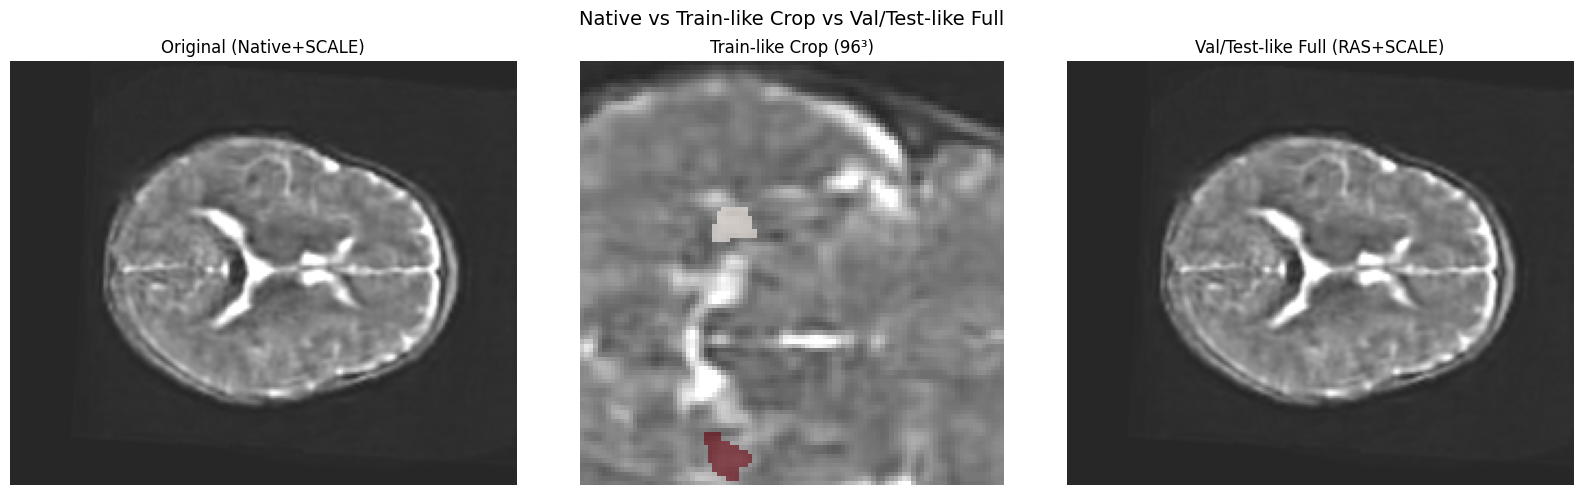

FG fraction — Original: 0.0005 | Train-like crop: 0.0039 | Val/Test-like: 0.0005


In [17]:
# =========================
# Cell 6 — Visualization (refined to match train / val-test)
# =========================
import numpy as np, matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, ResizeWithPadOrCropd,
    RandCropByPosNegLabeld
)

# --- CHANGED: use your global bounds from Cell 4.5 so viz matches training contrast
SCALE = ScaleIntensityRanged(
    keys=["image"],
    a_min=float(GLOBAL_A_MIN), a_max=float(GLOBAL_A_MAX),
    b_min=0.0, b_max=1.0, clip=True
)

# -------- Pipelines to visualize --------
# 1) Original/native (NO Orientationd): just to see raw grid
#    CHANGED: use SCALE (before was fixed 0→95)
original_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    SCALE,  # CHANGED: uses dataset-wide bounds
])

# 2) Train-like (Orientationd + SCALE + Crop + Resize)
#    CHANGED: use SCALE; matches your train preproc exactly
preprocess_train_like = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    SCALE,  # CHANGED
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 128)),
])

# 3) Val/Test-like (Orientationd + SCALE only; NO crop/resize)
#    NEW: mirrors val/test transforms so you can see what model sees there
preprocess_valtest_like = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    SCALE,  # CHANGED
])

# -------- Sample & crops --------
sample_data = train_data_dicts[0]

original = original_transform(sample_data)
train_like = preprocess_train_like(sample_data)
valtest_like = preprocess_valtest_like(sample_data)

# CHANGED: align with your train sampling plan (pos=8,neg=2 with enough samples)
crop_transform = RandCropByPosNegLabeld(
    keys=["image", "label"], label_key="label",
    spatial_size=(96, 96, 96),
    num_samples=10,   # CHANGED: let 8:2 materialize per call
    pos=8, neg=2,     # CHANGED: your chosen ratio for tiny hippocampus
    allow_smaller=True
)
cropped_samples = crop_transform(train_like)  # list of dicts
cropA = cropped_samples[0]  # show first crop

# -------- Helper to show a middle slice with label overlay --------
def show_middle_slice(image, label, title, ax):
    mid = image.shape[-1] // 2
    img_slice = image[0, :, :, mid]
    lab_slice = label[0, :, :, mid]
    ax.imshow(img_slice, cmap='gray', alpha=0.85)
    # Simple >0 mask overlay (red). If you want L/R colors, split ==1 and ==2.
    mask = np.ma.masked_where(lab_slice == 0, lab_slice)
    ax.imshow(mask, cmap='Reds', alpha=0.6)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# -------- Plot: Original vs Train-like crop vs Val/Test-like full --------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Native vs Train-like Crop vs Val/Test-like Full', fontsize=14)

show_middle_slice(original['image'],   original['label'],   'Original (Native+SCALE)', axes[0])
show_middle_slice(cropA['image'],      cropA['label'],      'Train-like Crop (96³)',  axes[1])
show_middle_slice(valtest_like['image'], valtest_like['label'], 'Val/Test-like Full (RAS+SCALE)', axes[2])

plt.tight_layout()
plt.show()

# -------- Quick stats (foreground fractions) --------
import torch  # add at top of the cell if not already imported

orig_fg = (original['label'] > 0).to(torch.float32).mean().item()
crop_fg = (cropA['label']    > 0).to(torch.float32).mean().item()
vt_fg   = (valtest_like['label'] > 0).to(torch.float32).mean().item()

print(f"FG fraction — Original: {orig_fg:.4f} | Train-like crop: {crop_fg:.4f} | Val/Test-like: {vt_fg:.4f}")

In [18]:
# =========================
# Cell 6: Model + Optimizer + Inferer (final)
# =========================
from monai.networks.nets import BasicUNet
from monai.inferers import SlidingWindowInferer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lighter UNet for 71 subjects
from monai.networks.nets import AttentionUnet

model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,   # background, left, right
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    dropout=0.1
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Plateau scheduler on validation Dice
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=8, min_lr=1e-6
)  # call: scheduler.step(val_dice)

# Match inference window to training patch (96^3)
inferer = SlidingWindowInferer(
    roi_size=(96, 96, 96), sw_batch_size=1, overlap=0.25, mode="gaussian"
)

print("Model params:", sum(p.numel() for p in model.parameters()))

Model params: 5909147


In [19]:
# =========================
# Cell 7: AMP scaler (unchanged)
# =========================
import torch
from torch.cuda.amp import GradScaler, autocast 

use_amp = torch.cuda.is_available()
scaler  = GradScaler(enabled=use_amp)
print(f"AMP enabled: {use_amp}")

AMP enabled: True


In [20]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-6):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.class_weights = torch.tensor([0.1, 10.0, 10.0]).to(device)

    def dice_loss(self, pred, target, class_idx):
        pred_class = pred[:, class_idx]
        target_class = (target == class_idx).float()
        intersection = (pred_class * target_class).sum()
        pred_sum = pred_class.sum()
        target_sum = target_class.sum()
        dice = (2.0 * intersection + self.smooth) / (pred_sum + target_sum + self.smooth)
        return 1 - dice

    

    def focal_loss(self, pred, target):
        ce_loss = F.cross_entropy(pred, target.long(), reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

    def forward(self, y_pred, y_true):
        if len(y_true.shape) == 5 and y_true.shape[1] == 1:
            y_true = y_true.squeeze(1)

        y_pred_soft = F.softmax(y_pred, dim=1)
        focal = self.focal_loss(y_pred, y_true)
        dice_left = self.dice_loss(y_pred_soft, y_true, 1)
        dice_right = self.dice_loss(y_pred_soft, y_true, 2)
        dice_loss = (dice_left + dice_right) / 2
        return 0.3 * focal + 0.7 * dice_loss

loss_function = FocalDiceLoss()

In [21]:
# =========================
# Cell 9: Metrics (REPLACE WHOLE CELL)
# =========================
from scipy import ndimage as ndi
import numpy as np
import torch

class SegmentationMetrics:
    """
    Per-case metrics for labels 1 (left) and 2 (right), plus L/R means.
    Distances are in mm if affine/spacing is provided.

    Metrics:
      - Dice Similarity Coefficient (DSC)
      - Hausdorff Distance (HD, max symmetric surface distance)
      - 95th percentile Hausdorff (HD95)
      - Average Symmetric Surface Distance (ASSD)
      - Relative Volume Error (RVE, %, absolute by default)
    """
    def __init__(self, include_background=False, num_classes=3, rve_abs=True):
        self.include_background = include_background
        self.num_classes = num_classes
        self.rve_abs = rve_abs
        self.reset()

    def reset(self):
        self.records = []

    @staticmethod
    def _to_np(x):
        return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

    @staticmethod
    def _spacing_from_affine_zyx(affine):
        """Return voxel spacing as (Z,Y,X) from a 4x4 affine."""
        if affine is None:
            return (1.0, 1.0, 1.0)
        A = np.asarray(affine)[:3, :3]
        sx, sy, sz = np.linalg.norm(A, axis=0)  # voxel sizes in X,Y,Z
        return (sz, sy, sx)  # -> Z,Y,X

    @staticmethod
    def _surface(mask):
        mask = mask.astype(bool, copy=False)
        if mask.sum() == 0:
            return mask
        struct = ndi.generate_binary_structure(3, 1)
        er = ndi.binary_erosion(mask, structure=struct, border_value=0)
        return mask & (~er)

    @staticmethod
    def _sym_surface_dists(a, b, spacing=(1.0, 1.0, 1.0)):
        a = a.astype(bool, copy=False)
        b = b.astype(bool, copy=False)
        if a.sum() == 0 or b.sum() == 0:
            return np.array([]), np.array([])
        sa = SegmentationMetrics._surface(a)
        sb = SegmentationMetrics._surface(b)
        if sa.sum() == 0 or sb.sum() == 0:
            return np.array([]), np.array([])
        dt_in_b  = ndi.distance_transform_edt(b,  sampling=spacing)
        dt_out_b = ndi.distance_transform_edt(~b, sampling=spacing)
        da = np.where(b[sa], dt_in_b[sa], dt_out_b[sa])
        dt_in_a  = ndi.distance_transform_edt(a,  sampling=spacing)
        dt_out_a = ndi.distance_transform_edt(~a, sampling=spacing)
        db = np.where(a[sb], dt_in_a[sb], dt_out_a[sb])
        return da, db

    @staticmethod
    def _dice(p, g):
        inter = (p & g).sum()
        den = p.sum() + g.sum()
        return float((2.0 * inter) / (den + 1e-6))

    def _per_class(self, pred_lab, gt_lab, cls, spacing_zyx):
        p, g = (pred_lab == cls), (gt_lab == cls)
        present_gt, present_p = g.sum() > 0, p.sum() > 0

        # Dice
        dice = self._dice(p, g) if (present_gt or present_p) else 1.0

        # RVE (volume-aware, %)
        rve = None
        if present_gt:
            voxvol = float(np.prod(spacing_zyx))
            v_gt = g.sum() * voxvol
            v_p  = p.sum() * voxvol
            rve = float(100.0 * (v_p - v_gt) / (v_gt + 1e-6))
            if self.rve_abs:
                rve = abs(rve)

        # Surface distances
        hd = hd95 = assd = None
        if present_gt and present_p:
            da, db = self._sym_surface_dists(p, g, spacing=spacing_zyx)
            both = np.concatenate([da, db]) if (da.size and db.size) else (da if da.size else db)
            if both.size:
                hd   = float(np.max(both))             # HD (max)
                hd95 = float(np.percentile(both, 95))  # 95HD
                assd = float(np.mean(both))            # ASSD

        return {"dice": dice, "rve": rve, "hd": hd, "hd95": hd95, "assd": assd}

    def update(self, pred_labels, gt_labels, affine=None, spacing=None):
        """
        spacing: optional (Z,Y,X) in mm. If None, derived from affine.
        """
        pred = self._to_np(pred_labels).astype(np.int16, copy=False)
        gt   = self._to_np(gt_labels).astype(np.int16, copy=False)

        if spacing is not None:
            s_zyx = tuple(float(v) for v in spacing)  # assume already Z,Y,X if provided
        elif affine is not None:
            s_zyx = self._spacing_from_affine_zyx(affine)
        else:
            s_zyx = (1.0, 1.0, 1.0)

        rec = {
            "left":  self._per_class(pred, gt, 1, s_zyx),
            "right": self._per_class(pred, gt, 2, s_zyx),
        }
        self.records.append(rec)

    def compute(self):
        """
        EXACTLY follows the wording:
        - compute per-case L/R mean for each metric,
        - then average across cases.
        Also returns side-wise means (diagnostics).
        """
        if not self.records:
            return {}

        def mean_of_per_case_lr(metric):
            per_case = []
            for r in self.records:
                lv = r["left"][metric]
                rv = r["right"][metric]
                if lv is None or rv is None or not np.isfinite(lv) or not np.isfinite(rv):
                    continue
                per_case.append(0.5 * (lv + rv))
            return float(np.mean(per_case)) if per_case else None

        def side_mean(side, metric):
            vals = [r[side][metric] for r in self.records
                    if r[side][metric] is not None and np.isfinite(r[side][metric])]
            return float(np.mean(vals)) if vals else None

        return {
            # FINAL scores per organizer wording (use these)
            "dice_mean_LR":    mean_of_per_case_lr("dice"),
            "hd_mean_LR_mm":   mean_of_per_case_lr("hd"),
            "hd95_mean_LR_mm": mean_of_per_case_lr("hd95"),
            "assd_mean_LR_mm": mean_of_per_case_lr("assd"),
            "rve_mean_LR_pct": mean_of_per_case_lr("rve"),

            # optional diagnostics
            "dice_left":     side_mean("left","dice"),
            "dice_right":    side_mean("right","dice"),
            "hd_left_mm":    side_mean("left","hd"),
            "hd_right_mm":   side_mean("right","hd"),
            "hd95_left_mm":  side_mean("left","hd95"),
            "hd95_right_mm": side_mean("right","hd95"),
            "assd_left_mm":  side_mean("left","assd"),
            "assd_right_mm": side_mean("right","assd"),
            "rve_left_pct":  side_mean("left","rve"),
            "rve_right_pct": side_mean("right","rve"),

            "num_cases": len(self.records),
        }

In [22]:
# =========================
# Cell 10: Define Training and Validation Functions
# =========================
import torch
import torch.nn.functional as F
import gc

# NOTE: remove DiceMetric imports/usages elsewhere

def train_model():
    """One epoch of training."""
    model.train()
    epoch_loss = 0.0

    for step, batch in enumerate(train_loader, 1):
        inputs = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)

        # labels must be integer class ids {0,1,2}
        if labels.ndim == 5 and labels.shape[1] == 1:
            labels = labels.squeeze(1)
        labels = labels.long().clamp_(0, 2)   # CHANGED: enforce valid class ids {0,1,2}


        optimizer.zero_grad(set_to_none=True)

        # AMP-friendly forward/backward
        if 'use_amp' in globals() and use_amp:
            with torch.cuda.amp.autocast():
                logits = model(inputs)
                loss = loss_function(logits, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(inputs)
            loss = loss_function(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        epoch_loss += float(loss.item())

    return epoch_loss / max(1, len(train_loader))


def _get_affine_from_batch(batch):
    """Robustly pull the affine from MONAI meta dict."""
    aff = None
    if "image_meta_dict" in batch and "affine" in batch["image_meta_dict"]:
        aff = batch["image_meta_dict"]["affine"]
        # handle batched/tensor cases
        if isinstance(aff, (list, tuple)):
            aff = aff[0]
        if torch.is_tensor(aff):
            aff = aff.cpu().numpy()
    return aff


def validate_model():
    """
    Returns:
      val_loss (float),
      val_dice (float): DSC averaged L/R per case, then across cases (challenge metric),
      res (dict): keys include dice_mean_LR, hd*_mean_LR_mm, assd_mean_LR_mm, rve_mean_LR_pct, plus per-side diags
    """
    model.eval()
    val_loss = 0.0
    metrics = SegmentationMetrics(rve_abs=True)  # uses affine for mm distances

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True)

            # shape/typing
            if labels.ndim == 5 and labels.shape[1] == 1:
                labels = labels.squeeze(1)
            labels = labels.long().clamp_(0, 2)   # CHANGED: enforce valid class ids {0,1,2}


            # WHOLE-VOLUME inference (uses your SlidingWindowInferer if defined)
            if 'inferer' in globals():
                logits = inferer(inputs, model)
            else:
                logits = model(inputs)  # okay if it fits memory

            # compute loss for logging
            if 'use_amp' in globals() and use_amp:
                with torch.cuda.amp.autocast():
                    loss = loss_function(logits, labels)
            else:
                loss = loss_function(logits, labels)
            val_loss += float(loss.item())

            # predictions: class ids (B,D,H,W)
            preds = torch.argmax(logits, dim=1)

            # ---- IMPORTANT: pass affine so HD/ASSD are in mm & RVE is volume-aware ----
            aff = _get_affine_from_batch(batch)

            # one update per subject (batch_size=1)
            metrics.update(
                pred_labels=preds[0].cpu().numpy(),
                gt_labels=labels[0].cpu().numpy(),
                affine=aff
            )

    res = metrics.compute()
    # Challenge DSC = mean of per-case (left/right) DSCs
    val_dice = res.get("dice_mean_LR", None)

    return val_loss / max(1, len(val_loader)), val_dice, res

In [23]:
# =========================
# Cell 11: Run Full Training Loop (Epochs + History + Checkpoints)
# =========================
import time
import numpy as np
import gc

print("STARTING TRAINING")
print("="*60)

history = {
    "train_loss": [], "val_loss": [], "val_dice": [],
    "val_hd": [], "val_hd95": [], "val_assd": [], "val_rve": [],
    "val_dice_L": [], "val_dice_R": []
}

best_dice = 0.0
no_improve, patience = 0, 20

best_model_path = str((MODEL_DIR / "hippocampus_best_model.pth") if 'MODEL_DIR' in globals() else "hippocampus_best_model.pth")
last_model_path = str((MODEL_DIR / "hippocampus_last.pth") if 'MODEL_DIR' in globals() else "hippocampus_last.pth")

max_epochs = 100

for epoch in range(max_epochs):
    epoch_t0 = time.time()
    print(f"\nEpoch {epoch + 1}/{max_epochs}")

    # ---- Train
    t0 = time.time()
    train_loss = train_model()
    if torch.cuda.is_available(): torch.cuda.synchronize()   # ensure kernels done before timing
    train_sec = time.time() - t0

    if not np.isfinite(train_loss):
        print("WARNING: non-finite train loss; skipping scheduler/model update this epoch.")
        continue

    # ---- Validate
    t0 = time.time()
    val_loss, val_dice, M = validate_model()
    if torch.cuda.is_available(): torch.cuda.synchronize()
    val_sec = time.time() - t0
    val_dice = float(M.get("dice_mean_LR") or 0.0)

    # ---- LR schedule
    if 'scheduler' in globals() and scheduler is not None:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_dice)
        else:
            scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # ---- History
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)
    history["val_hd"].append(M.get("hd_mean_LR_mm"))
    history["val_hd95"].append(M.get("hd95_mean_LR_mm"))
    history["val_assd"].append(M.get("assd_mean_LR_mm"))
    history["val_rve"].append(M.get("rve_mean_LR_pct"))
    history["val_dice_L"].append(M.get("dice_left"))
    history["val_dice_R"].append(M.get("dice_right"))

    # ---- Checkpoints
    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict() if ('scheduler' in globals() and scheduler is not None) else None,
            "epoch": epoch + 1,
            "best_dice": best_dice,
        },
        last_model_path,
    )

    # ---- Best model + Early stopping
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), best_model_path)
        print(f" NEW BEST MODEL! Dice (DSC avg L/R): {best_dice:.4f}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
            break

    # ---- Logs
    if torch.cuda.is_available(): torch.cuda.synchronize()
    epoch_sec = time.time() - epoch_t0
    train_ms_per_step = (train_sec / max(1, len(train_loader))) * 1000.0
    val_ms_per_step   = (val_sec   / max(1, len(val_loader)))   * 1000.0

    print("Epoch Results:")
    print(f"    Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(
        f"    DSC(avg L/R): {val_dice:.4f} | "
        f"HD(mean L/R, mm): {M.get('hd_mean_LR_mm')} | "
        f"95HD(mean L/R, mm): {M.get('hd95_mean_LR_mm')} | "
        f"ASSD(mean L/R, mm): {M.get('assd_mean_LR_mm')} | "
        f"RVE%(mean L/R): {M.get('rve_mean_LR_pct')} | "
        f"LR: {current_lr:.6f}"
    )
    print(
        f"    Time: epoch {epoch_sec:.1f}s | "
        f"train {train_sec:.1f}s ({train_ms_per_step:.0f} ms/step over {len(train_loader)} steps) | "
        f"val {val_sec:.1f}s ({val_ms_per_step:.0f} ms/step over {len(val_loader)} steps)"
    )
    print(f"    DSC_L: {M.get('dice_left')} | DSC_R: {M.get('dice_right')}")

    gc.collect()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print(f"Best Validation Dice (DSC avg L/R): {best_dice:.4f}")
print(f"Training Epochs: {len(history['train_loss'])}")
print("="*60)

STARTING TRAINING

Epoch 1/100
 NEW BEST MODEL! Dice (DSC avg L/R): 0.0004
Epoch Results:
    Train Loss: 0.7322 | Val Loss: 0.7273
    DSC(avg L/R): 0.0004 | HD(mean L/R, mm): 113.07156412183552 | 95HD(mean L/R, mm): 84.2416060496956 | ASSD(mean L/R, mm): 55.595243058145726 | RVE%(mean L/R): 13949.529183033237 | LR: 0.000500
    Time: epoch 289.2s | train 201.4s (6293 ms/step over 32 steps) | val 87.6s (5477 ms/step over 16 steps)
    DSC_L: 0.00031379049579163164 | DSC_R: 0.00046105794463095783

Epoch 2/100
Epoch Results:
    Train Loss: 0.7210 | Val Loss: 0.7191
    DSC(avg L/R): 0.0000 | HD(mean L/R, mm): 76.68572342591688 | 95HD(mean L/R, mm): 65.68274307147666 | ASSD(mean L/R, mm): 39.23568876955946 | RVE%(mean L/R): 80.27866753659954 | LR: 0.000500
    Time: epoch 268.4s | train 198.5s (6202 ms/step over 32 steps) | val 69.7s (4358 ms/step over 16 steps)
    DSC_L: 0.0 | DSC_R: 6.348400199924631e-05

Epoch 3/100
Epoch Results:
    Train Loss: 0.7160 | Val Loss: 0.7147
    DSC(av

In [24]:
from scipy import ndimage as ndi

def keep_largest_cc_per_class(lbl_np: np.ndarray) -> np.ndarray:
    out = lbl_np.copy()
    for cls in (1, 2):
        m = (out == cls)
        if m.sum() == 0:
            continue
        cc, num = ndi.label(m)
        if num > 1:
            sizes = np.bincount(cc.ravel()); sizes[0] = 0
            keep = sizes.argmax()
            out[(cc != keep) & (cc > 0)] = 0
    return out

In [25]:
# =========================
# Cell 12: Eval on the SAME local val loader used during training
# (no retraining; identical preprocessing/path as validate_model)
# =========================
from scipy import ndimage as ndi  # <-- ADD

def keep_largest_cc_per_class(lbl_np: np.ndarray) -> np.ndarray:  # <-- ADD
    out = lbl_np.copy()
    for cls in (1, 2):
        m = (out == cls)
        if m.sum() == 0:
            continue
        cc, num = ndi.label(m)
        if num > 1:
            sizes = np.bincount(cc.ravel()); sizes[0] = 0
            keep = sizes.argmax()
            out[(cc != keep) & (cc > 0)] = 0
    return out

import torch, numpy as np
from pathlib import Path

# --- sanity: we need the original val_loader/inferer and metrics helpers
assert 'val_loader' in globals(), "Run Cell 5 to define val_loader (no training needed)."
assert 'SegmentationMetrics' in globals(), "Run Cell 9 to define metrics."
assert 'inferer' in globals(), "Run Cell 6 to define the SlidingWindowInferer."
assert 'model' in globals() and 'device' in globals(), "Run Cell 6 to define model/device."

# --- load EXACT checkpoint you saved during training (Cell 11)
ckpt_path = MODEL_DIR / "hippocampus_best_model.pth"   # this is what Cell 11 wrote
if not ckpt_path.exists():
    # fallback to the "last" checkpoint if needed
    alt = MODEL_DIR / "hippocampus_last.pth"
    if not alt.exists():
        raise FileNotFoundError(f"No checkpoint found at {ckpt_path} or {alt}")
    ckpt_path = alt

ckpt = torch.load(ckpt_path, map_location=device)
state_dict = ckpt.get("model") or ckpt.get("state_dict") or ckpt
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print(f"Loaded checkpoint: {ckpt_path}")
print(f"Missing keys: {len(missing)} | Unexpected keys: {len(unexpected)}")

model.eval()

# --- eval over the SAME val_loader pipeline
metrics = SegmentationMetrics(rve_abs=True)
empty_pred_cases = 0
use_amp = torch.cuda.is_available()

# helper comes from Cell 10; make a safe fallback if it's missing
def _safe_affine(batch):
    try:
        return _get_affine_from_batch(batch)
    except NameError:
        return None

with torch.no_grad():
    for i, batch in enumerate(val_loader, 1):
        x = batch["image"].to(device)

        if use_amp:
            with torch.cuda.amp.autocast():
                logits = inferer(x, model)
        else:
            logits = inferer(x, model)

        pred_lbl = logits.argmax(1, keepdim=False)  # (1,D,H,W)
        pred_np = pred_lbl[0].cpu().numpy().astype(np.int16)          # <-- ADD
        pred_np = keep_largest_cc_per_class(pred_np)                  # <-- ADD


        y = batch["label"].to(device)
        y_lbl = y[:, 0].long() if (y.ndim == 5 and y.shape[1] == 1) else y.long()

        if i <= 3:
            pc = np.bincount(pred_lbl[0].cpu().numpy().ravel(), minlength=3)
            gc = np.bincount(y_lbl[0].cpu().numpy().ravel(),   minlength=3)
            print(f"   Pred counts [bg,L,R]={pc.tolist()} | GT={gc.tolist()}")

        if (pred_lbl[0] == 1).sum().item() + (pred_lbl[0] == 2).sum().item() == 0:
            empty_pred_cases += 1

        metrics.update(
            pred_labels=pred_np,                                       # <-- CHANGED
            gt_labels=y_lbl[0].cpu().numpy().astype(np.int16),
            affine=_safe_affine(batch),
        )
        print(f"Processed dev-val sample {i}/{len(val_loader)}")

# --- summary (same averaging as during training)
res = metrics.compute()
if empty_pred_cases > 0:
    print(f"\n[WARN] {empty_pred_cases}/{len(val_loader)} cases had ZERO foreground predicted.")

print("\nDEV VAL SUMMARY (LOCAL 20% SPLIT)")
print("="*60)
print(f"Cases: {res.get('num_cases', 0)}")
print(f"DSC  mean(L/R): {res.get('dice_mean_LR')}")
print(f"HD   mean(L/R) [mm]: {res.get('hd_mean_LR_mm')}")
print(f"95HD mean(L/R) [mm]: {res.get('hd95_mean_LR_mm')}")
print(f"ASSD mean(L/R) [mm]: {res.get('assd_mean_LR_mm')}")
print(f"RVE% mean(L/R): {res.get('rve_mean_LR_pct')}")
print(f"DSC_left/right:  {res.get('dice_left')} / {res.get('dice_right')}")
print(f"HD_left/right:   {res.get('hd_left_mm')} / {res.get('hd_right_mm')}")
print(f"95HD_left/right: {res.get('hd95_left_mm')} / {res.get('hd95_right_mm')}")
print(f"ASSD_left/right: {res.get('assd_left_mm')} / {res.get('assd_right_mm')}")
print(f"RVE_left/right:  {res.get('rve_left_pct')} / {res.get('rve_right_pct')}")

Loaded checkpoint: /kaggle/working/hippocampus_results/models/hippocampus_best_model.pth
Missing keys: 0 | Unexpected keys: 0
   Pred counts [bg,L,R]=[2094546, 1375, 1231] | GT=[2094758, 1180, 1214]
Processed dev-val sample 1/16
   Pred counts [bg,L,R]=[2093819, 1585, 1748] | GT=[2093880, 1674, 1598]
Processed dev-val sample 2/16
   Pred counts [bg,L,R]=[2094741, 1283, 1128] | GT=[2094202, 1279, 1671]
Processed dev-val sample 3/16
Processed dev-val sample 4/16
Processed dev-val sample 5/16
Processed dev-val sample 6/16
Processed dev-val sample 7/16
Processed dev-val sample 8/16
Processed dev-val sample 9/16
Processed dev-val sample 10/16
Processed dev-val sample 11/16
Processed dev-val sample 12/16
Processed dev-val sample 13/16
Processed dev-val sample 14/16
Processed dev-val sample 15/16
Processed dev-val sample 16/16

DEV VAL SUMMARY (LOCAL 20% SPLIT)
Cases: 16
DSC  mean(L/R): 0.5980702255544059
HD   mean(L/R) [mm]: 5.941742397762168
95HD mean(L/R) [mm]: 3.2228867356276787
ASSD mean

In [26]:
# =========================
# Cell 13: Inference & Submission on Official Validation/Test Set (robust meta handling)
# =========================

import csv, re, shutil, torch, numpy as np, nibabel as nib
from pathlib import Path
from scipy import ndimage as ndi

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    Orientationd, EnsureTyped, Invertd
)
from monai.data import Dataset, DataLoader, decollate_batch, MetaTensor
from monai.inferers import SlidingWindowInferer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Require SCALE from earlier cells (must match training normalization) ---
if "SCALE" not in globals():
    raise RuntimeError("SCALE not found. Please run the earlier cell where SCALE is defined.")

# ---- Paths ----
OFFVAL_DIR  = Path("/kaggle/input/subtask-2a-hippocampus-segmentations/Task 2 - Segmentation Validation")
OFFVAL_CSV  = Path("/kaggle/working/hippocampus_results/official_validation_files.csv")

OUTPUT_DIR  = Path("/kaggle/working/hippocampus_results")
MODEL_DIR   = OUTPUT_DIR / "models"
PRED_DIR    = OUTPUT_DIR / "predictions"
for d in (OUTPUT_DIR, MODEL_DIR, PRED_DIR):
    d.mkdir(parents=True, exist_ok=True)

# ---- Load best checkpoint into the already-built `model` ----
best_model_path = MODEL_DIR / "hippocampus_best_model.pth"
if best_model_path.exists():
    ckpt = torch.load(best_model_path, map_location=device)
    state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
    model.load_state_dict(state_dict, strict=True)
    print(f"Loaded best checkpoint: {best_model_path}")
else:
    print(f"WARNING: Best checkpoint not found at {best_model_path}. Using current model weights.")
model.eval()

# ---- Build official validation list ----
items = []
if OFFVAL_CSV.exists():
    with OFFVAL_CSV.open() as f:
        for row in csv.DictReader(f):
            items.append({"image": row["input_path"], "sid": row["sid"]})
else:
    for p in sorted(OFFVAL_DIR.glob("LISA_VALIDATION_*.nii*")):
        m = re.match(r"^LISA_VALIDATION_(\d+)(?:_ciso)?\.nii(\.gz)?$", p.name, flags=re.I)
        if m:
            items.append({"image": str(p), "sid": m.group(1)})

if not items:
    raise RuntimeError("No official validation/test images found. Check OFFVAL_DIR/OFFVAL_CSV.")

# ---- Naming ----
def make_outname(sid: str) -> str:
    return f"LISAHF{sid}segprediction.nii.gz"

# ---- Inference transform: match training (RAS + SCALE), track meta ----
# add to imports at top of Cell 13:
from monai.transforms import MaskIntensityd, CropForegroundd, ResizeWithPadOrCropd, DeleteItemsd
# make sure your MakeBrainMaskd class from Cell 5 is available in this notebook scope

offval_tx = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    SCALE,

    # NEW – mirror your val/test pipeline
    MakeBrainMaskd(keys=["image"]),
    MaskIntensityd(keys=["image"], mask_key="brain_mask"),
    CropForegroundd(keys=["image"], source_key="brain_mask"),
    ResizeWithPadOrCropd(keys=["image", "brain_mask"], spatial_size=(128, 128, 128)),
    DeleteItemsd(keys=["brain_mask"]),

    EnsureTyped(keys=["image"], track_meta=True),
])

offval_ds = Dataset(
    data=[{"image": it["image"], "sid": it["sid"]} for it in items],
    transform=offval_tx
)
offval_loader = DataLoader(
    offval_ds, batch_size=1, shuffle=False, num_workers=0,
    pin_memory=(device.type == "cuda")
)

# ---- Sliding-window inferer: match training patch (96^3) ----
inferer = SlidingWindowInferer(
    roi_size=(96, 96, 96), sw_batch_size=1, overlap=0.25, mode="gaussian"
)

# ---- Postprocess: keep largest connected component per class ----
def keep_largest_cc_per_class(lbl_np: np.ndarray) -> np.ndarray:
    out = lbl_np.copy()
    for cls in (1, 2):
        m = (out == cls)
        if m.sum() == 0:
            continue
        cc, num = ndi.label(m)
        if num > 1:
            sizes = np.bincount(cc.ravel()); sizes[0] = 0
            keep = sizes.argmax()
            out[(cc != keep) & (cc > 0)] = 0
    return out

# ---- Invertd pipeline to restore ORIGINAL orientation/space ----
invert_post = Compose([Invertd(
    keys="pred",
    transform=offval_tx,
    orig_keys="image",
    meta_keys="pred_meta_dict",
    orig_meta_keys="image_meta_dict",
    nearest_interp=True,
)])

use_amp = (device.type == "cuda")

with torch.inference_mode(): 
    for i, batch in enumerate(offval_loader, 1):
        # -------- Robust metadata handling (works with/without 'image_meta_dict') --------
        # Ensure we have an 'image_meta_dict' to satisfy Invertd and for saving.
        if "image_meta_dict" not in batch:
            img_mt = batch["image"]
            if isinstance(img_mt, MetaTensor):
                meta = img_mt.meta or {}
                batch["image_meta_dict"] = {
                    k: meta.get(k) for k in ("affine", "spatial_shape", "original_channel_dim", "filename_or_obj")
                }
            else:
                batch["image_meta_dict"] = {}

        # Try to get the source path; fall back to meta if needed.
        src_path = None
        if "filename_or_obj" in batch["image_meta_dict"] and batch["image_meta_dict"]["filename_or_obj"] is not None:
            src_path = batch["image_meta_dict"]["filename_or_obj"]
            if isinstance(src_path, (list, tuple)):
                src_path = src_path[0]

        # Inference in RAS space
        x = batch["image"].to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = inferer(x, model)                      # [B,C,H,W,D] in RAS
        pred = torch.argmax(logits, dim=1, keepdim=True).to(torch.int16)  # [B,1,H,W,D]

        # Attach meta and invert preprocessing
        batch["pred"] = pred
        batch["pred_meta_dict"] = batch["image_meta_dict"]
        dec = decollate_batch(batch)            # list of dicts, B=1 -> dec[0]
        dec = [invert_post(d) for d in dec]
        b = dec[0]

        # Back to numpy in ORIGINAL geometry
        pred_np = b["pred"].squeeze(0).cpu().numpy().astype(np.int16)

        # Enforce label set and cleanup
        pred_np = np.clip(pred_np, 0, 2).astype(np.int16)
        pred_np = keep_largest_cc_per_class(pred_np)

        # ---- Geometry (MICCAI rule: same shape & affine) ----
        if src_path is not None:
            nii_src     = nib.load(str(src_path))
            orig_affine = nii_src.affine
            orig_header = nii_src.header.copy()
            orig_shape  = nii_src.shape
        else:
            # Fall back to meta if path unavailable
            meta = b.get("image_meta_dict", {})
            orig_affine = np.array(meta.get("affine"))
            orig_shape  = tuple(meta.get("spatial_shape"))
            orig_header = nib.Nifti1Header()
            orig_header.set_data_dtype(np.int16)

        assert pred_np.shape == orig_shape, f"Pred {pred_np.shape} vs input {orig_shape}"

        # Output path & exact naming
        sid_raw = b["sid"] if "sid" in b else (batch["sid"][0] if isinstance(batch["sid"], (list, tuple)) else batch["sid"])
        sid = sid_raw if isinstance(sid_raw, str) else str(sid_raw)
        outpath = PRED_DIR / make_outname(sid)

        hdr = orig_header.copy() if hasattr(orig_header, "copy") else orig_header
        try:
            hdr.set_data_dtype(np.int16)
            hdr["scl_slope"] = 1
            hdr["scl_inter"] = 0
        except Exception:
            pass

        nib.save(nib.Nifti1Image(pred_np, orig_affine, hdr), str(outpath))

        # Quick MICCAI compliance checks
        assert outpath.exists(), f"Save failed for {outpath}"
        vals = set(np.unique(pred_np).tolist())
        assert vals.issubset({0, 1, 2}), f"Output contains labels outside {{0,1,2}}: {vals}"
        print(f"[{i}/{len(offval_loader)}] saved -> {outpath.name}")

# ---- Zip for submission ----
zip_base = OUTPUT_DIR / "LISALFSEG_predictions"
zip_path = zip_base.with_suffix(".zip")
if zip_path.exists():
    zip_path.unlink()
shutil.make_archive(str(zip_base), "zip", root_dir=str(PRED_DIR))
print(f"\n✅ Submit this file: {zip_path}")

Loaded best checkpoint: /kaggle/working/hippocampus_results/models/hippocampus_best_model.pth
[1/12] saved -> LISAHF0001segprediction.nii.gz
[2/12] saved -> LISAHF0002segprediction.nii.gz
[3/12] saved -> LISAHF0003segprediction.nii.gz
[4/12] saved -> LISAHF0004segprediction.nii.gz
[5/12] saved -> LISAHF0005segprediction.nii.gz
[6/12] saved -> LISAHF0006segprediction.nii.gz
[7/12] saved -> LISAHF0007segprediction.nii.gz
[8/12] saved -> LISAHF0008segprediction.nii.gz
[9/12] saved -> LISAHF0009segprediction.nii.gz
[10/12] saved -> LISAHF0010segprediction.nii.gz
[11/12] saved -> LISAHF0011segprediction.nii.gz
[12/12] saved -> LISAHF0012segprediction.nii.gz

✅ Submit this file: /kaggle/working/hippocampus_results/LISALFSEG_predictions.zip


VISUALIZING TRAINING HISTORY…


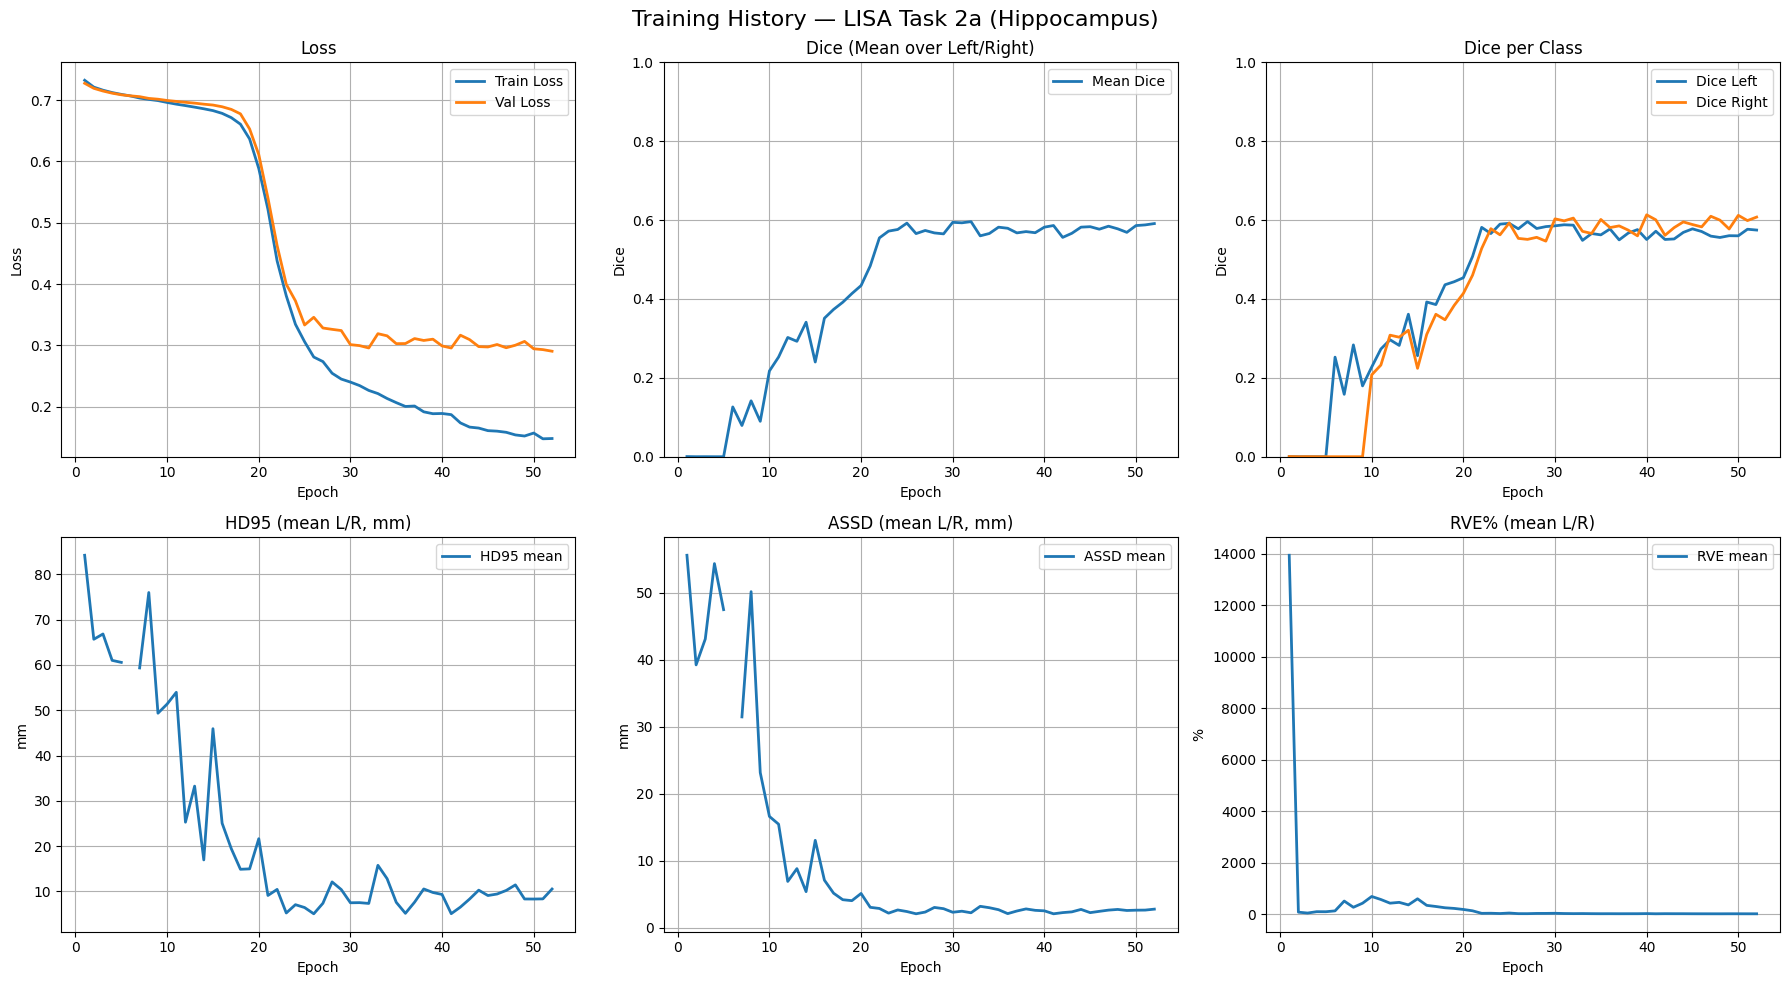


FINAL TRAINING STATISTICS
Final Train Loss: 0.1484
Final Val   Loss: 0.2907
Best Mean Dice (L/R): 0.5961 (Epoch 32)
Final Dice L/R: 0.5747 / 0.6076
Final HD95 (mean L/R, mm): 10.506255878129235
Final ASSD (mean L/R, mm): 2.7789945956318514
Final RVE% (mean L/R): 16.85047329351864


In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training curves for Task-2a metrics (robust to missing keys)."""

    def as_float_list(vs):
        return [np.nan if v is None else float(v) for v in vs]

    def series(*names):
        for k in names:
            if k in history and isinstance(history[k], (list, tuple)):
                return as_float_list(history[k]), k
        return [], None

    # pull series (with fallbacks to names you actually logged)
    train_loss,  _       = series('train_loss')
    val_loss,    _       = series('val_loss')
    mean_dice,   md_key  = series('val_dice', 'val_dice_monai', 'dice_mean_LR')
    dice_L,      _       = series('val_dice_L', 'dice_left')
    dice_R,      _       = series('val_dice_R', 'dice_right')
    hd95_mean,   _       = series('val_hd95', 'hd95_mean_LR_mm')
    assd_mean,   _       = series('val_assd', 'assd_mean_LR_mm')
    rve_mean,    _       = series('val_rve', 'rve_mean_LR_pct')
    lr_series,   _       = series('lr')  # only if you log it

    # choose epoch count from the longest available series
    lengths = [len(s) for s in [train_loss, val_loss, mean_dice, dice_L, dice_R, hd95_mean, assd_mean, rve_mean, lr_series] if len(s)]
    n_epochs = max(lengths) if lengths else 0
    epochs = list(range(1, n_epochs + 1))

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History — LISA Task 2a (Hippocampus)', fontsize=16)

    # helpers
    def line_or_na(ax, x, y, title, ylabel, ylim=None, labels=('A','B')):
        ax.set_title(title); ax.set_xlabel('Epoch'); ax.set_ylabel(ylabel); ax.grid(True)
        drew = False
        if len(y) == len(x) and len(y):
            ax.plot(x, y, label=labels[0], linewidth=2); drew = True
        if not drew:
            ax.text(0.5, 0.5, 'N/A (not logged)', ha='center', va='center', transform=ax.transAxes)
        if ylim: ax.set_ylim(*ylim)
        if drew: ax.legend()

    def two_lines_or_na(ax, x, y1, y2, title, ylabel, ylim=None, labels=('Left','Right')):
        ax.set_title(title); ax.set_xlabel('Epoch'); ax.set_ylabel(ylabel); ax.grid(True)
        drew = False
        if len(y1) == len(x) and len(y1):
            ax.plot(x, y1, label=labels[0], linewidth=2); drew = True
        if len(y2) == len(x) and len(y2):
            ax.plot(x, y2, label=labels[1], linewidth=2); drew = True
        if not drew:
            ax.text(0.5, 0.5, 'N/A (not logged)', ha='center', va='center', transform=ax.transAxes)
        if ylim: ax.set_ylim(*ylim)
        if drew: ax.legend()

    # (1) Loss
    ax = axes[0,0]
    ax.set_title('Loss'); ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.grid(True)
    drew = False
    if len(train_loss) == n_epochs:
        ax.plot(epochs, train_loss, label='Train Loss', linewidth=2); drew = True
    if len(val_loss) == n_epochs:
        ax.plot(epochs, val_loss,   label='Val Loss',   linewidth=2); drew = True
    if not drew:
        ax.text(0.5, 0.5, 'N/A (not logged)', ha='center', va='center', transform=ax.transAxes)
    else:
        ax.legend()

    # (2) Mean Dice
    line_or_na(axes[0,1], epochs, mean_dice, 'Dice (Mean over Left/Right)', 'Dice', ylim=(0,1), labels=('Mean Dice',))

    # (3) Per-class Dice
    two_lines_or_na(axes[0,2], epochs, dice_L, dice_R, 'Dice per Class', 'Dice', ylim=(0,1), labels=('Dice Left','Dice Right'))

    # (4) HD95 mean (mm)
    line_or_na(axes[1,0], epochs, hd95_mean, 'HD95 (mean L/R, mm)', 'mm', labels=('HD95 mean',))

    # (5) ASSD mean (mm)
    line_or_na(axes[1,1], epochs, assd_mean, 'ASSD (mean L/R, mm)', 'mm', labels=('ASSD mean',))

    # (6) LR or RVE mean (%)
    if len(lr_series) == n_epochs and len(lr_series):
        line_or_na(axes[1,2], epochs, lr_series, 'Learning Rate', 'LR', labels=('LR',))
    else:
        line_or_na(axes[1,2], epochs, rve_mean, 'RVE% (mean L/R)', '%', labels=('RVE mean',))

    plt.tight_layout()
    plt.show()

    # ---- Summary ----
    def last(vs): 
        return vs[-1] if len(vs) else float('nan')
    def best_with_epoch(vs, higher_is_better=True):
        if not len(vs): return (float('nan'), -1)
        arr = np.array(vs, dtype=float)
        if higher_is_better:
            idx = int(np.nanargmax(arr))
        else:
            idx = int(np.nanargmin(arr))
        return (float(arr[idx]), idx + 1)

    best_md, best_md_ep = best_with_epoch(mean_dice, True)

    print("\n" + "="*60)
    print("FINAL TRAINING STATISTICS")
    print("="*60)
    print(f"Final Train Loss: {last(train_loss):.4f}")
    print(f"Final Val   Loss: {last(val_loss):.4f}")
    if np.isfinite(best_md):
        print(f"Best Mean Dice (L/R): {best_md:.4f} (Epoch {best_md_ep})")
    print(f"Final Dice L/R: {last(dice_L):.4f} / {last(dice_R):.4f}")
    print(f"Final HD95 (mean L/R, mm): {last(hd95_mean)}")
    print(f"Final ASSD (mean L/R, mm): {last(assd_mean)}")
    if len(rve_mean):
        print(f"Final RVE% (mean L/R): {last(rve_mean)}")
    if len(lr_series):
        print(f"Final LR: {last(lr_series)}")
    print("="*60)

print("VISUALIZING TRAINING HISTORY…")
plot_training_history(history)

In [34]:
# =========================
# Cell: Write strict TEST-PHASE Docker assets (Task 2a) + export weights
# =========================
import os, textwrap, torch
from pathlib import Path

# --- paths
ROOT = Path("/kaggle/working/docker"); ROOT.mkdir(parents=True, exist_ok=True)
WTS  = ROOT / "weights";               WTS.mkdir(parents=True, exist_ok=True)

# --- 1) export weights from your current model (ATTENTION UNET from Cell 6)
assert "model" in globals(), "Model not found. Run training or load your best weights first."
torch.save(model.state_dict(), str(WTS / "model.pt"))  # <-- pure state_dict (has 'model.' keys)
print("✔ Saved weights ->", WTS / "model.pt")

# --- 2) write predict.py (STRICT: /input -> /output, Task 2a naming)
predict_py = '''\
# predict.py — LISA Task 2a TEST PHASE ONLY: /input -> /output (Attention U-Net)
import os, re, torch, numpy as np, nibabel as nib
from pathlib import Path
from scipy import ndimage as ndi
from monai.transforms import (Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
                              EnsureTyped, Invertd, ScaleIntensityRangePercentilesd,
                              ScaleIntensityRanged, MaskIntensityd, CropForegroundd,
                              ResizeWithPadOrCropd, DeleteItemsd, MapTransform)

from monai.data import Dataset, DataLoader, decollate_batch, MetaTensor
from monai.inferers import SlidingWindowInferer
from monai.networks.nets import AttentionUnet

# ----- I/O (evaluator mounts) -----
IN_DIR, OUT_DIR = Path("/input"), Path("/output")
if not (IN_DIR.exists() and OUT_DIR.exists()):
    raise RuntimeError("Evaluator will mount /input and /output. They must exist.")

class MakeBrainMaskd(MapTransform):
    """Conservative brain mask from intensities (percentile + morphology)."""
    def __init__(self, keys=("image",)):
        super().__init__(keys)
    def __call__(self, data):
        d = dict(data); img = d["image"]  # (C,D,H,W) after EnsureChannelFirstd
        x = img[0] if img.ndim == 4 else img
        arr = np.asarray(x, dtype=np.float32)
        thr = np.percentile(arr[arr > arr.mean()/4], 60) if np.any(arr > 0) else np.percentile(arr, 60)
        m = arr > thr
        m = ndi.binary_fill_holes(m)
        m = ndi.binary_opening(m, iterations=1)
        m = ndi.binary_dilation(m, iterations=2)
        d["brain_mask"] = (m[None]).astype(np.uint8)
        return d

# ----- Model (MATCH YOUR TRAINING: AttentionUnet channels/strides/dropout) -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,                 # 0=bg, 1=left, 2=right
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    dropout=0.1
).to(device)

def _strip_module(sd):
    # only remove 'module.' (DataParallel); DO NOT strip 'model.' (needed by MONAI nets)
    out = {}
    for k, v in sd.items():
        if k.startswith("module."):
            k = k[7:]
        out[k] = v
    return out

ckpt = torch.load("/opt/model.pt", map_location=device)
state = ckpt["state_dict"] if (isinstance(ckpt, dict) and "state_dict" in ckpt) else ckpt
state = _strip_module(state)

# strict load first; if it ever fails, try a fall-back that ADDS 'model.' prefix
try:
    missing, unexpected = model.load_state_dict(state, strict=True), ()
except Exception as e:
    # Fall-back: add 'model.' if keys are missing it
    state2 = { (k if k.startswith("model.") else "model."+k): v for k, v in state.items() }
    model.load_state_dict(state2, strict=True)

model.eval()
use_amp = (device.type == "cuda")

# ----- Discovery & naming (Task 2a TEST: exact underscore naming) -----
TEST_PAT = re.compile(r"^LISA_TESTING_(\\d{4,})_ciso\\.nii(\\.gz)?$", re.I)
def make_outname(sid: str) -> str:
    return f"LISA_TESTING_SEG_{sid}_hipp.nii.gz"

items = []
for p in sorted(IN_DIR.glob("*.nii*")):
    m = TEST_PAT.search(p.name)
    if m:
        items.append({"image": str(p), "sid": m.group(1)})
if not items:
    raise RuntimeError("No TEST images in /input. Expect files like LISA_TESTING_0001_ciso.nii.gz")

# ----- Intensity scale (ENV overrides; else robust percentile) -----
try:
    a_min = float(os.environ.get("A_MIN")) if os.environ.get("A_MIN") else None
    a_max = float(os.environ.get("A_MAX")) if os.environ.get("A_MAX") else None
except ValueError:
    a_min, a_max = None, None

if a_min is not None and a_max is not None:
    SCALE = ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True)
else:
    SCALE = ScaleIntensityRangePercentilesd(keys=["image"], lower=0.5, upper=99.5, b_min=0.0, b_max=1.0, clip=True)

pre = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Orientationd(keys=["image"], axcodes="RAS"),
    SCALE,
    MakeBrainMaskd(keys=["image"]),
    MaskIntensityd(keys=["image"], mask_key="brain_mask"),
    CropForegroundd(keys=["image"], source_key="brain_mask"),
    ResizeWithPadOrCropd(keys=["image","brain_mask"], spatial_size=(128,128,128)),
    DeleteItemsd(keys=["brain_mask"]),
    EnsureTyped(keys=["image"], track_meta=True),
])


ds = Dataset(items, transform=pre)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=(device.type=="cuda"))
inferer = SlidingWindowInferer(roi_size=(96,96,96), sw_batch_size=1, overlap=0.25, mode="gaussian")

def keep_lcc(lbl):
    out = lbl.copy()
    for cls in (1, 2):
        m = (out == cls)
        if m.sum() == 0: 
            continue
        cc, num = ndi.label(m)
        if num > 1:
            sizes = np.bincount(cc.ravel()); sizes[0] = 0
            keep = sizes.argmax()
            out[(cc != keep) & (cc > 0)] = 0
    return out

invert = Compose([Invertd(
    keys="pred", transform=pre, orig_keys="image",
    meta_keys="pred_meta_dict", orig_meta_keys="image_meta_dict",
    nearest_interp=True
)])

with torch.no_grad():
    for batch in loader:
        # ensure meta dict exists (for Invertd & saving)
        if "image_meta_dict" not in batch:
            img_mt = batch["image"]
            if isinstance(img_mt, MetaTensor):
                meta = img_mt.meta or {}
                batch["image_meta_dict"] = {k: meta.get(k) for k in ("affine","spatial_shape","original_channel_dim","filename_or_obj")}
            else:
                batch["image_meta_dict"] = {}

        src = batch["image_meta_dict"].get("filename_or_obj")
        src_path = src[0] if isinstance(src, (list, tuple)) else src
        if src_path is None:
            raise RuntimeError("Missing filename in metadata.")

        x = batch["image"].to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = inferer(x, model)
        pred = torch.argmax(logits, dim=1, keepdim=True).to(torch.int16)  # save as int16

        batch["pred"] = pred
        batch["pred_meta_dict"] = batch["image_meta_dict"]
        dec = decollate_batch(batch)
        dec = [invert(d) for d in dec]
        b = dec[0]

        arr = b["pred"].squeeze(0).cpu().numpy().astype(np.int16)
        arr[~np.isin(arr, (0,1,2))] = 0
        arr = keep_lcc(arr)

        src_img = nib.load(str(src_path))
        affine  = src_img.affine
        header  = src_img.header.copy()
        shape   = src_img.shape
        assert arr.shape == shape, f"Pred {arr.shape} vs input {shape}"

        sid = TEST_PAT.search(os.path.basename(src_path)).group(1)
        outpath = OUT_DIR / make_outname(sid)

        try:
            header.set_data_dtype(np.int16); header["scl_slope"] = 1; header["scl_inter"] = 0
        except Exception:
            pass

        nib.save(nib.Nifti1Image(arr, affine, header), str(outpath))
'''

# --- 3) entrypoint.sh
entrypoint_sh = "#!/usr/bin/env bash\nset -euo pipefail\npython /app/predict.py\n"

# --- 4) Dockerfile (pinned; no network at eval)
dockerfile = '''\
FROM pytorch/pytorch:2.3.1-cuda12.1-cudnn8-runtime

RUN apt-get update && apt-get install -y --no-install-recommends \
    libglib2.0-0 libgl1 && rm -rf /var/lib/apt/lists/*

RUN pip install --no-cache-dir \
    monai==1.3.2 nibabel==5.2.1 numpy==1.26.4 scipy==1.11.4 scikit-image==0.22.0 SimpleITK==2.3.1

ENV A_MIN=-0.003
ENV A_MAX=9.454

WORKDIR /app
COPY weights/model.pt /opt/model.pt
COPY predict.py /app/predict.py
COPY entrypoint.sh /app/entrypoint.sh
RUN chmod +x /app/entrypoint.sh

# If you want to force exact training scale at runtime, you may set:
# ENV A_MIN=0 A_MAX=95

ENTRYPOINT ["/app/entrypoint.sh"]
'''

# --- write files
(Path(ROOT/"predict.py")).write_text(textwrap.dedent(predict_py))
(Path(ROOT/"entrypoint.sh")).write_text(entrypoint_sh)
(Path(ROOT/"Dockerfile")).write_text(textwrap.dedent(dockerfile))

print("✔ Wrote", ROOT/"predict.py")
print("✔ Wrote", ROOT/"entrypoint.sh")
print("✔ Wrote", ROOT/"Dockerfile")
print("\nDownload the folder:", ROOT)
print("Then build/push/submit your Docker as per the challenge instructions.")

✔ Saved weights -> /kaggle/working/docker/weights/model.pt
✔ Wrote /kaggle/working/docker/predict.py
✔ Wrote /kaggle/working/docker/entrypoint.sh
✔ Wrote /kaggle/working/docker/Dockerfile

Download the folder: /kaggle/working/docker
Then build/push/submit your Docker as per the challenge instructions.


In [35]:
import shutil
shutil.make_archive('/kaggle/working/lisa2a_docker', 'zip', '/kaggle/working/docker')
print("Created: /kaggle/working/lisa2a_docker.zip")

Created: /kaggle/working/lisa2a_docker.zip


In [45]:
# Check
import nibabel as nib, numpy as np, glob, os
for p in glob.glob("/kaggle/working/hippocampus_results/predictions/*.nii.gz"):
    a = nib.load(p)
    d = np.asanyarray(a.dataobj).astype(np.int16)
    vals, cnt = np.unique(d, return_counts=True)
    print(os.path.basename(p), a.shape, dict(zip(vals.tolist(), cnt.tolist())))

LISAHF0009segprediction.nii.gz (195, 233, 159) {0: 7221599, 1: 1209, 2: 1357}
LISAHF0012segprediction.nii.gz (197, 233, 189) {0: 8672708, 1: 1354, 2: 1227}
LISAHF0008segprediction.nii.gz (197, 233, 189) {0: 8672996, 1: 1152, 2: 1141}
LISAHF0007segprediction.nii.gz (195, 233, 159) {0: 7220928, 1: 1494, 2: 1743}
LISAHF0006segprediction.nii.gz (195, 233, 159) {0: 7220825, 1: 1627, 2: 1713}
LISAHF0010segprediction.nii.gz (197, 233, 189) {0: 8671614, 1: 1850, 2: 1825}
LISAHF0004segprediction.nii.gz (197, 233, 189) {0: 8673750, 1: 701, 2: 838}
LISAHF0002segprediction.nii.gz (195, 233, 159) {0: 7221456, 1: 1150, 2: 1559}
LISAHF0011segprediction.nii.gz (197, 233, 189) {0: 8672417, 1: 1339, 2: 1533}
LISAHF0003segprediction.nii.gz (195, 233, 159) {0: 7220661, 1: 1808, 2: 1696}
LISAHF0001segprediction.nii.gz (195, 233, 159) {0: 7221400, 1: 1254, 2: 1511}
LISAHF0005segprediction.nii.gz (195, 233, 159) {0: 7220959, 1: 1612, 2: 1594}


In [37]:
from IPython.display import FileLink, display
display(FileLink('lisa2a_docker.zip'))  # note: no leading /kaggle/working

/kaggle/working/lisa2a_docker.zip